In [1]:
import os
os.environ["http_proxy"]="127.0.0.1:7890"
os.environ["https_proxy"]="127.0.0.1:7890"

In [2]:
from openai import OpenAI

api_key = ""
api_base = ""
client = OpenAI(api_key=api_key, base_url=api_base)

dialogue_model = "gpt-4o-mini" # "gpt-3.5-turbo"
embed_model = 'text-embedding-3-large' # 嵌入用个贵的

In [3]:
import tiktoken

# 初始化encoding
encoding = tiktoken.get_encoding("cl100k_base")

In [4]:
import pandas as pd

# 加载数据
data = pd.read_csv('data/training_data.csv')
data.head(5)

,text,label
0,I need to retrieve 10 papers on the impact of ...,Education
1,Please find 10 papers on online learning effec...,Education
2,Can you get 10 papers about the role of assess...,Education
3,Investigate the relationship between socioecon...,Education
4,I'm interested in 8 papers on the implementati...,Education


# 看下text列转化成token之后的长度来决定max_len

In [5]:
import re
import numpy as np

# 先看看所有数据中的token数的分布
encoding = tiktoken.encoding_for_model(embed_model) # 实例化

# 数据预处理函数
def preprocess_text(text):
    # 去掉标点符号
    text = re.sub(r'[^\w\s]', '', text)
    # 转为小写
    text = text.lower()
    # 编码文本
    tokens = encoding.encode(text)
    return tokens

# 应用预处理函数
data['tokens'] = data['text'].apply(preprocess_text)

# 计算统计信息的函数
def calculate_token_statistics(tokens_list):
    # 计算每行tokens的长度
    token_lengths = [len(tokens) for tokens in tokens_list]
    
    # 统计信息
    max_len = np.max(token_lengths)
    min_len = np.min(token_lengths)
    mean_len = np.mean(token_lengths)
    median_len = np.median(token_lengths)
    q1 = np.percentile(token_lengths, 25)
    q3 = np.percentile(token_lengths, 75)
    
    stats = {
        'max_len': max_len,
        'min_len': min_len,
        'mean_len': mean_len,
        'median_len': median_len,
        'q1': q1,
        'q3': q3
    }
    
    return stats

# 计算统计信息
tokens_list = data['tokens'].tolist()
stats = calculate_token_statistics(tokens_list)

print(stats)

{'max_len': 42, 'min_len': 13, 'mean_len': 22.866, 'median_len': 22.0, 'q1': 20.0, 'q3': 25.0}


# training_data的q3为25 -> 所以我们选择30

In [6]:
# 定义最大长度
max_len = 30

In [7]:
# 先看看所有数据中的token数的分布
encoding = tiktoken.encoding_for_model(embed_model) # 实例化

# 数据预处理函数
def preprocess_text(text):
    # 去掉标点符号
    text = re.sub(r'[^\w\s]', '', text)
    # 转为小写
    text = text.lower()
    # 编码文本
    tokens = encoding.encode(text)
    return tokens

# 将tokens转化为字母的函数
def tokens_to_letters(tokens):
    letters = [encoding.decode_single_token_bytes(token).decode('utf-8') for token in tokens]
    return letters

# 应用预处理函数和字母转化函数
data['tokens'] = data['text'].apply(preprocess_text)
data['letters'] = data['tokens'].apply(tokens_to_letters)

data.head(5)

,text,label,tokens,letters
0,I need to retrieve 10 papers on the impact of ...,Education,"[72, 1205, 311, 17622, 220, 605, 16064, 389, 2...","[i, need, to, retrieve, , 10, papers, on..."
1,Please find 10 papers on online learning effec...,Education,"[31121, 1505, 220, 605, 16064, 389, 2930, 6975...","[please, find, , 10, papers, on, online, ..."
2,Can you get 10 papers about the role of assess...,Education,"[4919, 499, 636, 220, 605, 16064, 922, 279, 35...","[can, you, get, , 10, papers, about, the..."
3,Investigate the relationship between socioecon...,Education,"[43114, 65056, 279, 5133, 1990, 80431, 2704, 3...","[invest, igate, the, relationship, between,..."
4,I'm interested in 8 papers on the implementati...,Education,"[318, 8173, 304, 220, 23, 16064, 389, 279, 829...","[im, interested, in, , 8, papers, on, th..."


In [8]:
import pickle
from collections import defaultdict

# 保存embedding_cache到文件
def save_embedding_cache(cache, filename='embedding_cache.pkl'):
    # 转换为普通的dict
    cache_dict = dict(cache)
    with open(filename, 'wb') as f:
        pickle.dump(cache_dict, f)

# 从文件加载embedding_cache
def load_embedding_cache(filename='embedding_cache.pkl'):
    with open(filename, 'rb') as f:
        cache_dict = pickle.load(f)
    # 重新构建defaultdict并设置默认值
    cache = defaultdict(lambda: None, cache_dict)
    return cache

# 缓存字母嵌入向量的字典
# embedding_cache = defaultdict(lambda: None)

# 加载embedding_cache
embedding_cache = load_embedding_cache()
print(len(embedding_cache["please"]))

3072


In [9]:
import time
import torch

# 开始计时
start_time = time.time()

# 获取单个字母嵌入的函数
def get_single_letter_embedding(letter):
    if embedding_cache[letter] is not None:
        return embedding_cache[letter]
    
    response = client.embeddings.create(input=letter, model=embed_model)
    embedding = response.data[0].embedding
    embedding_cache[letter] = embedding
    return embedding

# 获取句子嵌入的函数
def get_sentence_embedding(letters, max_len):
    embeddings = [get_single_letter_embedding(letter) for letter in letters]
    embeddings = torch.tensor(embeddings)

    # 填充或截断
    if embeddings.shape[0] < max_len:
        padding = torch.zeros((max_len - embeddings.shape[0], embeddings.shape[1]))
        embeddings = torch.cat((embeddings, padding), dim=0)
    else:
        embeddings = embeddings[:max_len]

    return embeddings

# 获取嵌入向量并填充或截断为同样长度的张量
data['embeddings'] = data['letters'].apply(lambda x: get_sentence_embedding(x, max_len))

# 结束计时
end_time = time.time()
# 计算时间差
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# 打印处理后的数据
data.head(5)

# 如果需要保存处理后的数据
data.to_csv('data/processed_training_data.csv', index=False)

# 保存embedding_cache
save_embedding_cache(embedding_cache)

Elapsed time: 28.979148864746094 seconds


In [10]:
# 转化为模型的输出张量
embeddings_tensor = torch.stack(data['embeddings'].tolist())

# 打印处理后的数据
print(embeddings_tensor.shape)  # 打印张量的形状
# print(embeddings_tensor)

torch.Size([1500, 30, 3072])


In [11]:
label_encoder = {label: idx for idx, label in enumerate(data['label'].unique())}
data['label'] = data['label'].map(label_encoder)
labels_tensor = torch.tensor(data['label'].values)
len(labels_tensor), labels_tensor

(1500, tensor([0, 0, 0,  ..., 4, 4, 4]))

In [12]:
from torch.utils.data import Dataset, DataLoader, random_split

# 定义数据集类
class TextEmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return {
            'embeddings': self.embeddings[idx],
            'labels': self.labels[idx]
        }

# 创建数据集
dataset = TextEmbeddingDataset(embeddings_tensor, labels_tensor)

# 划分训练集和测试集
total_size = len(dataset)
train_size = int(total_size * 0.7)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 打印数据加载器的批次数
print(f'Train loader batch count: {len(train_loader)}')
print(f'Test loader batch count: {len(test_loader)}')

Train loader batch count: 17
Test loader batch count: 8


In [13]:
for loader in train_loader:
    embeddings = loader["embeddings"]
    labels = loader["labels"]
    print(embeddings.shape, "\n", labels.shape)
    # print(embeddings)
    break

torch.Size([64, 30, 3072]) 
 torch.Size([64])


# 1.TextCNN

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

In [15]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [16]:
from models.VGGTextCNN import VGGTextCNN

# 创建模型实例
num_classes = len(data['label'].unique())
model = VGGTextCNN(num_classes)
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# 训练和评估函数
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        embeddings = batch['embeddings'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(embeddings.unsqueeze(1))  # 增加通道维度
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings.unsqueeze(1))  # 增加通道维度
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

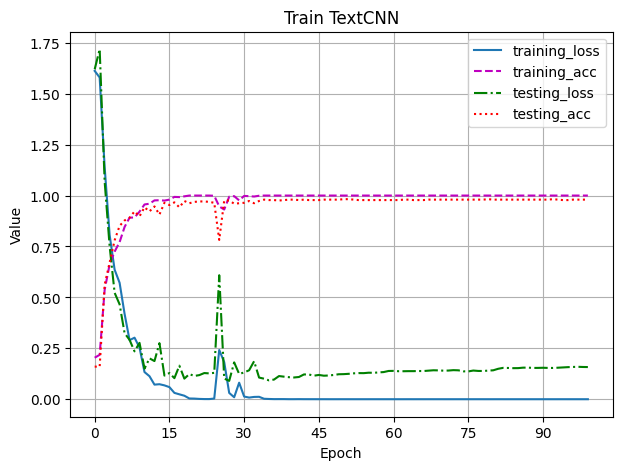

In [18]:
from visualization import TrainingVisualizer
from save_load_checkpoint import save_checkpoint

visualizer = TrainingVisualizer(xlabel='Epoch', ylabel='Value', title='Train TextCNN', legend=['training_loss', "training_acc", "testing_loss", "testing_acc"])  

# 训练模型
num_epochs = 100
best_train_acc = 0.0
best_val_acc = 0.0  # 初始化最佳验证准确率
model_path = 'checkpoints/TextCNN/TextCNN.pth'
optimizer_path = 'checkpoints/TextCNN/optimizer.pth'

for epoch in range(num_epochs):
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = eval_model(model, test_loader, criterion, device)
    
    train_acc = train_acc.cpu().item() if isinstance(train_acc, torch.Tensor) else train_acc
    val_acc = val_acc.cpu().item() if isinstance(val_acc, torch.Tensor) else val_acc
    
    visualizer.add(epoch, [train_loss, train_acc, val_loss, val_acc])

    if train_acc > best_train_acc:
        best_train_acc = train_acc
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_checkpoint(model, optimizer, epoch + 1, model_path, optimizer_path)

In [19]:
best_train_acc, best_val_acc

(1.0, 0.9822222222222222)

In [20]:
from save_load_checkpoint import load_checkpoint

model_path = 'checkpoints/TextCNN/TextCNN.pth'
optimizer_path = 'checkpoints/TextCNN/optimizer.pth'

# 加载模型和优化器状态
model, optimizer, start_epoch = load_checkpoint(model, optimizer, model_path, optimizer_path)

Loaded model and optimizer states from checkpoints/TextCNN/TextCNN.pth and checkpoints/TextCNN/optimizer.pth, starting from epoch 51.


C:\Users\20703\generative-ai-for-beginners\MyTest\save_load_checkpoint.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


### 接着训练

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = eval_model(model, test_loader, criterion, device)

    # print(f'Epoch {epoch + 1}/{num_epochs}')
    # print(f'Train loss {train_loss:.4f}, accuracy {train_acc:.4f}')
    # print(f'Val loss {val_loss:.4f}, accuracy {val_acc:.4f}')
    visualizer.add(epoch+100, [train_loss, train_acc, val_loss, val_acc])

In [ ]:
train_acc, val_acc

In [ ]:
model_path = 'checkpoints/TextCNN/TextCNN.pth'
optimizer_path = 'checkpoints/TextCNN/optimizer.pth'

# 保存模型和优化器状态
save_checkpoint(model, optimizer, num_epochs+100, model_path, optimizer_path)

# 2.TextRNN

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import re
import pickle
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader, random_split
from openai import OpenAI
import tiktoken
import os

In [28]:
from models.TextRNN_GPT import TextRNN

In [29]:
print(embeddings_tensor.shape, len(label_encoder))

torch.Size([1500, 30, 3072]) 5


In [30]:
# 设置参数
embedding_dim = embeddings_tensor.shape[2]
hidden_dim = 128
output_dim = len(label_encoder)
n_layers = 2
bidirectional = True
dropout = 0.5

# 创建模型实例
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextRNN(embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
# 训练和评估函数
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        embeddings = batch['embeddings'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

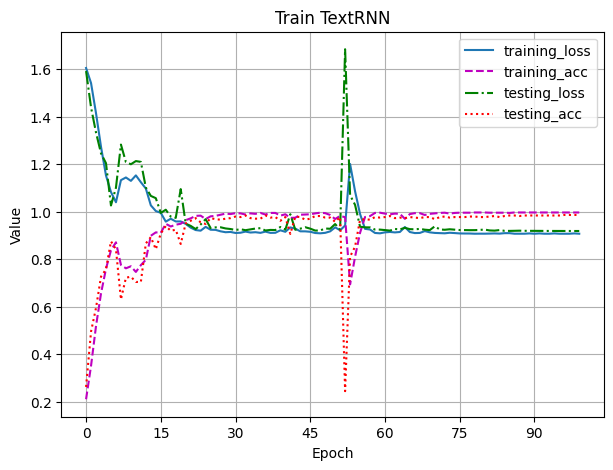

In [32]:
from visualization import TrainingVisualizer
from save_load_checkpoint import save_checkpoint

visualizer = TrainingVisualizer(xlabel='Epoch', ylabel='Value', title='Train TextRNN', legend=['training_loss', "training_acc", "testing_loss", "testing_acc"])  

# 训练模型
num_epochs = 100
best_train_acc = 0.0
best_val_acc = 0.0  # 初始化最佳验证准确率
model_path = 'checkpoints/TextRNN/TextRNN.pth'
optimizer_path = 'checkpoints/TextRNN/optimizer.pth'

for epoch in range(num_epochs):
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = eval_model(model, test_loader, criterion, device)
    
    train_acc = train_acc.cpu().item() if isinstance(train_acc, torch.Tensor) else train_acc
    val_acc = val_acc.cpu().item() if isinstance(val_acc, torch.Tensor) else val_acc
    
    visualizer.add(epoch, [train_loss, train_acc, val_loss, val_acc])

    if train_acc > best_train_acc:
        best_train_acc = train_acc
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_checkpoint(model, optimizer, epoch + 1, model_path, optimizer_path)

In [33]:
best_train_acc, best_val_acc

(0.9971428571428571, 0.9866666666666667)

In [34]:
from save_load_checkpoint import load_checkpoint

model_path = 'checkpoints/TextRNN/TextRNN.pth'
optimizer_path = 'checkpoints/TextRNN/optimizer.pth'

# 加载模型和优化器状态
model, optimizer, start_epoch = load_checkpoint(model, optimizer, model_path, optimizer_path)

Loaded model and optimizer states from checkpoints/TextRNN/TextRNN.pth and checkpoints/TextRNN/optimizer.pth, starting from epoch 97.


# 3.TextRCNN

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import re
import pickle
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader, random_split
from openai import OpenAI
import tiktoken
import os

In [36]:
# 定义TextRCNN模型
from models.TextRCNN import TextRCNN

# 设置参数
embedding_dim = embeddings_tensor.shape[2]
hidden_dim = 128
output_dim = len(label_encoder)
n_layers = 2
bidirectional = True
dropout = 0.5

# 创建模型实例
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextRCNN(max_len, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
# 训练和评估函数
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        embeddings = batch['embeddings'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

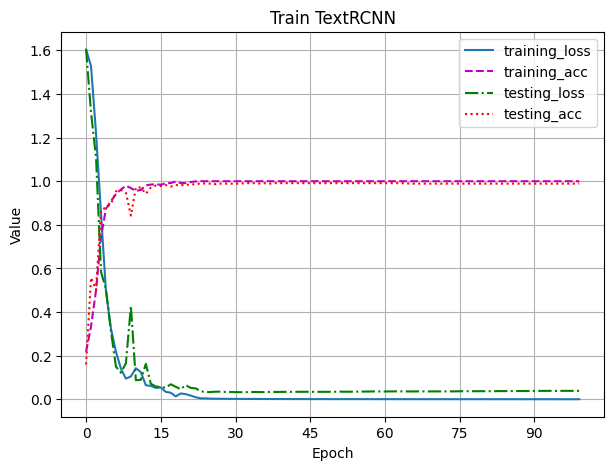

In [38]:
from visualization import TrainingVisualizer
from save_load_checkpoint import save_checkpoint

visualizer = TrainingVisualizer(xlabel='Epoch', ylabel='Value', title='Train TextRCNN', legend=['training_loss', "training_acc", "testing_loss", "testing_acc"])  

# 训练模型
num_epochs = 100
best_train_acc = 0.0
best_val_acc = 0.0  # 初始化最佳验证准确率
model_path = 'checkpoints/TextRCNN/TextRCNN.pth'
optimizer_path = 'checkpoints/TextRCNN/optimizer.pth'

for epoch in range(num_epochs):
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = eval_model(model, test_loader, criterion, device)
    
    train_acc = train_acc.cpu().item() if isinstance(train_acc, torch.Tensor) else train_acc
    val_acc = val_acc.cpu().item() if isinstance(val_acc, torch.Tensor) else val_acc
    
    visualizer.add(epoch, [train_loss, train_acc, val_loss, val_acc])

    if train_acc > best_train_acc:
        best_train_acc = train_acc
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_checkpoint(model, optimizer, epoch + 1, model_path, optimizer_path)

In [39]:
train_acc, val_acc

(1.0, 0.9888888888888889)

In [40]:
from save_load_checkpoint import load_checkpoint

model_path = 'checkpoints/TextRCNN/TextRCNN.pth'
optimizer_path = 'checkpoints/TextRCNN/optimizer.pth'

# 加载模型和优化器状态
model, optimizer, start_epoch = load_checkpoint(model, optimizer, model_path, optimizer_path)

Loaded model and optimizer states from checkpoints/TextRCNN/TextRCNN.pth and checkpoints/TextRCNN/optimizer.pth, starting from epoch 24.


# 现在对于任意的用户请求，我们需要进行一些转化并输出预测结果和概率

In [ ]:
import pandas as pd
import torch
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
class VGGTextCNN(nn.Module):
    def __init__(self, num_classes):
        super(VGGTextCNN, self).__init__()
        
        # 第一层卷积块
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=(3, 3072))
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=(3, 1))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 1))
        
        # 第二层卷积块
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=(3, 1))
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=(3, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 1))
        
        # 第三层卷积块 - seq_size设置为18时，第二层卷积结束已经torch.Size([16, 128, 1, 1])，所以弃用第三个卷积block
        # self.conv3_1 = nn.Conv2d(128, 256, kernel_size=(3, 1))
        # self.conv3_2 = nn.Conv2d(256, 256, kernel_size=(3, 1))
        # self.pool3 = nn.MaxPool2d(kernel_size=(2, 1))
        
        # 全连接层
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 输入形状：(batch_size, 1, max_len, 768)
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        # print("1:", x.shape)

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        # print("2:", x.shape)

        # x = F.relu(self.conv3_1(x))
        # x = F.relu(self.conv3_2(x))
        # x = self.pool3(x)
        # print("3:", x.shape)

        x = x.view(x.size(0), -1)
        # print("Flatten:", x.shape)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

data = pd.read_csv("processed_training_data.csv")

# 创建模型实例
num_classes = len(data['label'].unique())
model = VGGTextCNN(num_classes)
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model_path = 'checkpoints/TextCNN/TextCNN.pth'
optimizer_path = 'checkpoints/TextCNN/optimizer.pth'

# 加载模型和优化器状态
def load_checkpoint(model, optimizer, model_path, optimizer_path):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f'Loaded model and optimizer states from {model_path} and {optimizer_path}, starting from epoch {epoch}.')
    return model, optimizer, epoch
    
# 加载模型和优化器状态
model, optimizer, start_epoch = load_checkpoint(model, optimizer, model_path, optimizer_path)

# 加载训练好的模型
model = model.to(device)
model.eval()

In [ ]:
import os
os.environ["http_proxy"]="127.0.0.1:7890"
os.environ["https_proxy"]="127.0.0.1:7890"

In [ ]:
from openai import OpenAI

api_key = "sk-FCDYB07IqQG164cC9604D8096d2e4e44B7CdF8684e19A51f"
api_base = "https://api.zetatechs.com/v1"
client = OpenAI(api_key=api_key, base_url=api_base)

dialogue_model = "gpt-4o-mini" # "gpt-3.5-turbo"
embed_model = 'text-embedding-3-large' # 嵌入用个贵的

In [ ]:
import tiktoken

# 初始化encoding
encoding = tiktoken.get_encoding("cl100k_base")

# 先看看所有数据中的token数的分布
encoding = tiktoken.encoding_for_model(embed_model) # 实例化

In [ ]:
import pickle
from collections import defaultdict

# 从文件加载embedding_cache
def load_embedding_cache(filename='embedding_cache.pkl'):
    with open(filename, 'rb') as f:
        cache_dict = pickle.load(f)
    # 重新构建defaultdict并设置默认值
    cache = defaultdict(lambda: None, cache_dict)
    return cache
    
# 加载embedding_cache
embedding_cache = load_embedding_cache()

In [ ]:
max_len = 24

In [ ]:
import re

# 加载label_encoder
label_encoder = {label: idx for idx, label in enumerate(data['label'].unique())}
idx_to_label = {idx: label for label, idx in label_encoder.items()}

# 数据预处理函数
def preprocess_user_input(text, max_len):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = encoding.encode(text)
    letters = [encoding.decode_single_token_bytes(token).decode('utf-8') for token in tokens]
    embeddings = [get_single_letter_embedding(letter) for letter in letters]
    embeddings = torch.tensor(embeddings)

    if embeddings.shape[0] < max_len:
        padding = torch.zeros((max_len - embeddings.shape[0], embeddings.shape[1]))
        embeddings = torch.cat((embeddings, padding), dim=0)
    else:
        embeddings = embeddings[:max_len]

    return embeddings.unsqueeze(0).unsqueeze(1)  # 增加batch维度，然后增加通道数

# 获取单个字母嵌入的函数
def get_single_letter_embedding(letter):
    if embedding_cache[letter] is not None:
        return embedding_cache[letter]
    
    response = client.embeddings.create(input=letter, model=embed_model)
    embedding = response.data[0].embedding
    embedding_cache[letter] = embedding
    return embedding

# 预测函数
def predict(text):
    with torch.no_grad():
        embeddings = preprocess_user_input(text, max_len).to(device)
        outputs = model(embeddings)
        probabilities = F.softmax(outputs, dim=1).squeeze()
        print(probabilities)
        predicted_idx = torch.argmax(probabilities).item()
        predicted_label = idx_to_label[predicted_idx]
        predicted_prob = probabilities[predicted_idx].item()
        
    return predicted_label, predicted_prob

In [ ]:
# 示例用户请求
user_request = "what is the positional encoding?"
predicted_label, predicted_prob = predict(user_request)

print(f"Predicted label: {predicted_label}, Probability: {predicted_prob}")